In [1]:
#Import general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Import libraries useful for building the pipeline and join their branches
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin


#import modules created for data preparation phase
import my_utils
import missing_val_imput
import feature_select
import preprocessing
import adhoc_transf

#import libraries for data preparation phase
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder


#import libraries from modelling phase
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef

#import classifiers
#import Ensemble Trees Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier
import xgboost as xgb

#to save model fit with GridSearchCV and avoid longer waits
import joblib


c:\Users\xdpemo\Anaconda3\envs\XAI-HF\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
c:\Users\xdpemo\Anaconda3\envs\XAI-HF\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
###########################################################################
#  Explainability Analisys
# The "most explainable" classifier is ExtraTrees by assessing the FIR ratio
# Different explainability method are considered: implicit feature importance, feature permutation, SHAP and PDP
###########################################################################


#Loading the dataset
path_data=r'C:\Users\xdpemo\OneDrive - TUNI.fi\Documents\GitHub\Heart_Failure_Predictor\heart_failure_clinical_records_dataset.csv'

df=pd.read_csv(path_data)
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
#%%
###################################################################################################################
##Step 1.1 Winsorization strategies to set the outliers to the values of 10 and 90 percentiles
####################################################################


def winsorize_percentiles(df, columns, lower_percentile, upper_percentile):
    for column in columns:
        lower_limit = df[column].quantile(lower_percentile/100)
        upper_limit = df[column].quantile(upper_percentile/100)
        df[column] = df[column].clip(lower_limit, upper_limit)
    return df

# Example usage

columns_to_winsorize = ['creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium',]
lower_percentile = 0
upper_percentile = 90

df = winsorize_percentiles(df, columns_to_winsorize, lower_percentile, upper_percentile)

In [5]:
target_feature='DEATH_EVENT'
numerical_feats=['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']
nominal_feats=['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

df=adhoc_transf.ageRounder().fit_transform(df)
my_utils.df_values(df)



>>>>>>>>Calling init() from ageRounder

>>>>>>>>Calling fit() from ageRounder

>>>>>>>>Calling transform() from ageRounder

>>>>>>>>Calling rounder
*****start of feature  age *************************
60.0    33
50.0    27
65.0    26
70.0    25
45.0    19
55.0    17
75.0    11
58.0    10
53.0    10
63.0     8
42.0     7
40.0     7
72.0     7
80.0     7
61.0     6
85.0     6
52.0     5
68.0     5
62.0     5
49.0     4
59.0     4
73.0     4
51.0     4
64.0     3
46.0     3
69.0     3
82.0     3
90.0     3
66.0     2
78.0     2
54.0     2
77.0     2
57.0     2
44.0     2
67.0     2
95.0     2
48.0     2
43.0     1
86.0     1
81.0     1
79.0     1
41.0     1
94.0     1
87.0     1
47.0     1
56.0     1
Name: age, dtype: int64
*****end of feature  age ************************** 

*****start of feature  anaemia *************************
0    170
1    129
Name: anaemia, dtype: int64
*****end of feature  anaemia ************************** 

*****start of feature  creatinine_phosphokinase *****

In [6]:
###################################################################################################################
#Step 1 Solving wrong characters of dataset
###################################################################################################################

#Performing numeric cast for numerical features
df.loc[:,numerical_feats]=adhoc_transf.Numeric_Cast_Column().fit_transform(df.loc[:,numerical_feats])
df[numerical_feats].dtypes

#Performing category cast for nominal features
df.loc[:,nominal_feats]=adhoc_transf.Category_Cast_Column().fit_transform(df.loc[:,nominal_feats])
df[nominal_feats].dtypes



>>>>>>>>Calling init() from Numeric_Cast_Column

>>>>>>>>Calling fit() from Numeric_Cast_Column

>>>>>>>>Calling transform() from Numeric_Cast_Column

>>>>>>>>Calling init() from Category_Cast_Column

>>>>>>>>Calling fit() from Category_Cast_Column

>>>>>>>>Calling transform() from Category_Cast_Column


anaemia                category
diabetes               category
high_blood_pressure    category
sex                    category
smoking                category
dtype: object

In [7]:
###################################################################################################################
##Step 2 Train-Test splitting
###################################################################################################################

#Split the dataset into train and test
test_ratio_split=0.3
train_set,test_set=train_test_split(df, test_size=test_ratio_split, random_state=42, stratify=df[target_feature])

X_train=train_set.drop(target_feature,axis=1)
y_train=train_set[target_feature].copy()

X_test=test_set.drop(target_feature,axis=1)
y_test=test_set[target_feature].copy()


In [8]:
###################################################################################################################
##Step 3 Label Encoding of target value
###################################################################################################################
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.fit_transform(y_test)
le.classes_


array([0, 1], dtype=int64)

In [9]:
###################################################################################################################
##Step 4 Building pipelines for data preparation
###################################################################################################################

#Lets define 3 pipeline mode
#a) parallel approach where feature selection is performed in parallel 
# for numerical, nominal and categorical
#b) general approach where feature selection is performed as a whole for other features
#c) no feature selection is performed

#Before a data preprocessing will take place for each type of feature
pipeline_numeric_feat=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])

pipeline_numeric_feat_mean=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='mean')),
                                 ('scaler', MinMaxScaler())])

pipeline_nominal_feat=Pipeline([('data_missing',missing_val_imput.Category_Imputer()),                                 
                                 ('encoding', OrdinalEncoder())])#We dont use OneHotEncoder since it enlarges the number of nominal features 

pipeline_ordinal_feat=Pipeline([ ('data_missing',missing_val_imput.Category_Imputer(strategy='most_frequent')),
                                 ('encoding', OrdinalEncoder())])


#option a)
pipe_numeric_featsel=Pipeline([('data_prep',pipeline_numeric_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_nominal_featsel=Pipeline([('data_prep',pipeline_nominal_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_ordinal_featsel=Pipeline([('data_prep',pipeline_ordinal_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])

dataprep_pipe_opta=ColumnTransformer([('numeric_pipe',pipe_numeric_featsel,numerical_feats),
                                    ('nominal_pipe',pipe_nominal_featsel,nominal_feats)
                                ])



 Mon Jun  5 16:18:15 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Mon Jun  5 16:18:15 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Mon Jun  5 16:18:15 2023 >>>>>>>>Calling init() from Category_Imputer

 Mon Jun  5 16:18:15 2023 >>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector


In [10]:
###################################################################################################################
##Step 5 Tailoring the dataset with the feature selected of the best classifier
###################################################################################################################

features_selected_xtree=['age','ejection_fraction','serum_creatinine','time','diabetes']
X_train_feat_sel=X_train[features_selected_xtree]
X_test_feat_sel=X_test[features_selected_xtree]

extratree_clf=ExtraTreesClassifier(random_state=42)


In [11]:
###################################################################################################################
##Step 6 The estimator is refited with those feature selected
#########################################################

numerical_feats_xtree=['age','ejection_fraction','serum_creatinine','time']
nominal_feats_xtree=['diabetes']


dataprep_merge_feat_xtree=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_mean,numerical_feats_xtree),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats_xtree)
                                    ])



In [12]:
X_train_featsel=dataprep_merge_feat_xtree.fit_transform(X_train_feat_sel)
df_X_train_featsel=pd.DataFrame(X_train_featsel, columns=features_selected_xtree)
df_X_train_featsel.head()

X_test_featsel=dataprep_merge_feat_xtree.fit_transform(X_test_feat_sel)
df_X_test_featsel=pd.DataFrame(X_test_featsel, columns=features_selected_xtree)
df_X_test_featsel.head()

extratree_clf.fit(df_X_train_featsel,y_train)



 Mon Jun  5 16:18:55 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Mon Jun  5 16:18:55 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Mon Jun  5 16:18:55 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:18:55 2023 >>>>>>>>Calling init() from Category_Imputer

 Mon Jun  5 16:18:55 2023 >>>>>>>>Calling fit() from Category_Imputer

 Mon Jun  5 16:18:55 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:18:55 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Mon Jun  5 16:18:55 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Mon Jun  5 16:18:55 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:18:55 2023 >>>>>>>>Calling init() from Category_Imputer

 Mon Jun  5 16:18:55 2023 >>>>>>>>Calling fit() from Category_Imputer

 Mon Jun  5 16:18:55 2023 >>>>>>>>Calling transform() from Category_Imputer


ExtraTreesClassifier(random_state=42)

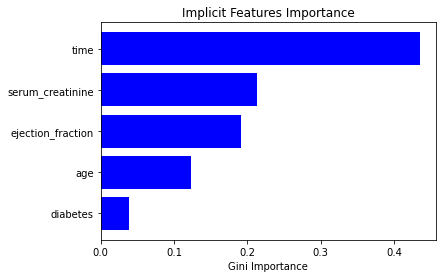

In [13]:
###################################################################################################################
##Step 7 Implicit feature importance
#####################################################

importances = extratree_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Implicit Features Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features_selected_xtree[i] for i in indices])
plt.xlabel('Gini Importance')
plt.show()


In [14]:
import eli5
from eli5 import show_weights
eli5.explain_weights(extratree_clf, feature_names=features_selected_xtree)


Weight,Feature
0.4349 ± 0.1765,time
0.2129 ± 0.1259,serum_creatinine
0.1913 ± 0.0819,ejection_fraction
0.1228 ± 0.0717,age
0.0381 ± 0.0389,diabetes


In [15]:
feat_imp_df = eli5.explain_weights_df(extratree_clf, feature_names=features_selected_xtree)
feat_imp_df

,feature,weight,std
0,time,0.434892,0.088243
1,serum_creatinine,0.212948,0.062954
2,ejection_fraction,0.191252,0.040931
3,age,0.122846,0.035874
4,diabetes,0.038062,0.019469


In [16]:
result = feat_imp_df.sort_values(['weight'], ascending=False, ignore_index=True)
result

,feature,weight,std
0,time,0.434892,0.088243
1,serum_creatinine,0.212948,0.062954
2,ejection_fraction,0.191252,0.040931
3,age,0.122846,0.035874
4,diabetes,0.038062,0.019469


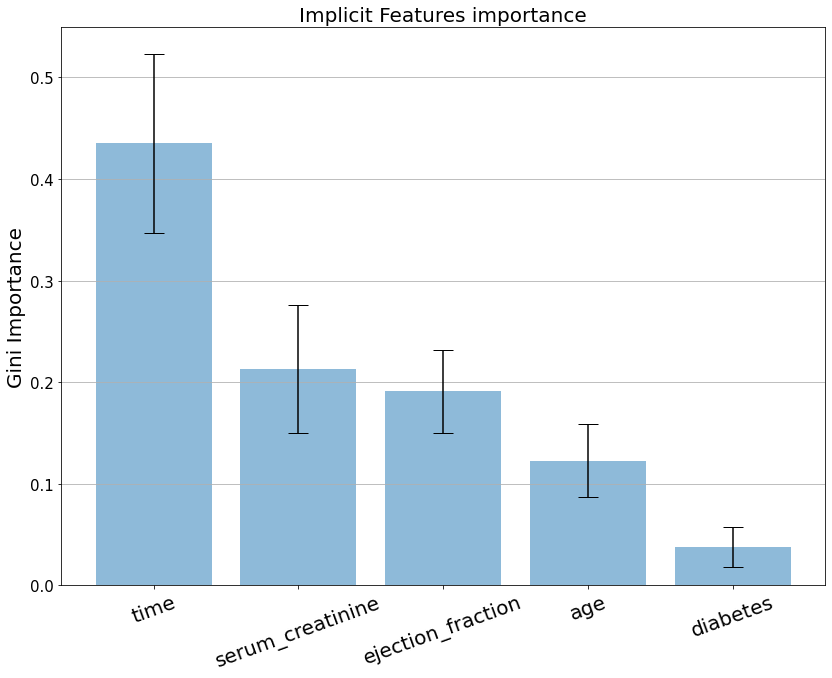

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 10.27)
ax.bar(result['feature'], result['weight'], yerr=result['std'], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Gini Importance', fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.set_xticks(result['feature'])
ax.set_xticklabels(result['feature'], fontsize=20,rotation=20 )
ax.set_title('Implicit Features importance', fontsize=20)
ax.yaxis.grid(True)

In [18]:
# Implicit feature importance for local explainability
###############################################################

y_pred = extratree_clf.predict(df_X_test_featsel)
print('y_pred',y_pred)
print('y_test',y_test)

y_pred [0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1
 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1]
y_test [0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1
 0 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0]


In [19]:
y_pred_train = extratree_clf.predict(df_X_train_featsel)
print('y_pred_train',y_pred_train)
print('y_train',y_train)



y_pred_train [1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1
 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1
 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0
 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]
y_train [1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1
 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1
 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0
 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]


In [20]:
#predicting true negative - the patient IS ALIVE
index_TN = 0
print(df_X_test_featsel.iloc[index_TN])
print(X_test_feat_sel.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred[index_TN])
eli5.explain_prediction(extratree_clf,df_X_test_featsel.iloc[index_TN], feature_names=features_selected_xtree)



age                  0.218182
ejection_fraction    0.347826
serum_creatinine     0.066667
time                 0.377698
diabetes             0.000000
Name: 0, dtype: float64
age                   52.0
ejection_fraction     30.0
serum_creatinine       0.7
time                 112.0
diabetes               0.0
Name: 146, dtype: float64
Actual Label: 0
Predicted Label: 0


Explanation(estimator='ExtraTreesClassifier(random_state=42)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.6794258373205738, std=None, value=1.0), FeatureWeight(feature='time', weight=0.08626924982830693, std=None, value=0.37769784172661874), FeatureWeight(feature='serum_creatinine', weight=0.06959023668887744, std=None, value=0.06666666666666665), FeatureWeight(feature='ejection_fraction', weight=0.03393432123735088, std=None, value=0.34782608695652173), FeatureWeight(feature='diabetes', weight=0.024326636162833752, std=None, value=0.0)], neg=[FeatureWeight(feature='age', weight=-0.023546281237943098, std=None, value=0.21818181818181814)], pos_remaining=0, neg_remaining=0), proba=0.87, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [21]:
#predicting true postive - the patient IS DEAD
index_TP = 2
print(df_X_test_featsel.iloc[index_TP])
print(X_test_feat_sel.iloc[index_TP])
print('Actual Label:', y_test[index_TP])
print('Predicted Label:', y_pred[index_TP])
eli5.explain_prediction(extratree_clf,df_X_test_featsel.iloc[index_TP], feature_names=features_selected_xtree)


age                  0.636364
ejection_fraction    0.521739
serum_creatinine     1.000000
time                 0.010791
diabetes             0.000000
Name: 2, dtype: float64
age                  75.0
ejection_fraction    38.0
serum_creatinine      2.1
time                 10.0
diabetes              0.0
Name: 10, dtype: float64
Actual Label: 1
Predicted Label: 1


Explanation(estimator='ExtraTreesClassifier(random_state=42)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='time', weight=0.4090831846930972, std=None, value=0.010791366906474816), FeatureWeight(feature='<BIAS>', weight=0.3205741626794251, std=None, value=1.0), FeatureWeight(feature='serum_creatinine', weight=0.20642165166266985, std=None, value=1.0), FeatureWeight(feature='ejection_fraction', weight=0.014053518140600425, std=None, value=0.5217391304347826)], neg=[FeatureWeight(feature='diabetes', weight=-0.024614702927234697, std=None, value=0.0), FeatureWeight(feature='age', weight=-0.005517814248558591, std=None, value=0.6363636363636362)], pos_remaining=0, neg_remaining=0), proba=0.92, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [22]:
#predicting true negative - the patient IS ALIVE - FOR TRAINING INSTANCE
index_TN_train = 1
print(df_X_train_featsel.iloc[index_TN_train])
print(X_train_feat_sel.iloc[index_TN_train])
print('Actual Label:', y_train[index_TN_train])
print('Predicted Label:', y_pred_train[index_TN_train])
eli5.explain_prediction(extratree_clf,df_X_train_featsel.iloc[index_TN_train], feature_names=features_selected_xtree)


age                  0.090909
ejection_fraction    0.222222
serum_creatinine     0.187500
time                 0.824818
diabetes             1.000000
Name: 1, dtype: float64
age                   45.0
ejection_fraction     25.0
serum_creatinine       0.8
time                 230.0
diabetes               1.0
Name: 258, dtype: float64
Actual Label: 0
Predicted Label: 0


Explanation(estimator='ExtraTreesClassifier(random_state=42)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.6794258373205738, std=None, value=1.0), FeatureWeight(feature='time', weight=0.2209759705389915, std=None, value=0.8248175182481752), FeatureWeight(feature='serum_creatinine', weight=0.15885860698027118, std=None, value=0.1875), FeatureWeight(feature='age', weight=0.06491919184014097, std=None, value=0.09090909090909083), FeatureWeight(feature='diabetes', weight=0.0006680884793616232, std=None, value=1.0)], neg=[FeatureWeight(feature='ejection_fraction', weight=-0.12484769515933941, std=None, value=0.2222222222222222)], pos_remaining=0, neg_remaining=0), proba=1.0, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [23]:
#predicting true negative - the patient IS ALIVE - FOR TRAINING INSTANCE
index_TP_train = 7
print(df_X_train_featsel.iloc[index_TP_train])
print(X_train_feat_sel.iloc[index_TP_train])
print('Actual Label:', y_train[index_TP_train])
print('Predicted Label:', y_pred_train[index_TP_train])
eli5.explain_prediction(extratree_clf,df_X_train_featsel.iloc[index_TP_train], feature_names=features_selected_xtree)

###################################################################################################################
##Step 8 Feature permutation importance
#############################################################

age                  0.909091
ejection_fraction    0.555556
serum_creatinine     1.000000
time                 0.014599
diabetes             0.000000
Name: 7, dtype: float64
age                  90.0
ejection_fraction    40.0
serum_creatinine      2.1
time                  8.0
diabetes              0.0
Name: 5, dtype: float64
Actual Label: 1
Predicted Label: 1


Explanation(estimator='ExtraTreesClassifier(random_state=42)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='time', weight=0.35015055787393407, std=None, value=0.014598540145985401), FeatureWeight(feature='<BIAS>', weight=0.3205741626794251, std=None, value=1.0), FeatureWeight(feature='serum_creatinine', weight=0.20097762434666439, std=None, value=1.0), FeatureWeight(feature='age', weight=0.12325399517970781, std=None, value=0.909090909090909), FeatureWeight(feature='ejection_fraction', weight=0.01793089938015538, std=None, value=0.5555555555555556)], neg=[FeatureWeight(feature='diabetes', weight=-0.012887239459887363, std=None, value=0.0)], pos_remaining=0, neg_remaining=0), proba=1.0, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [25]:
# With X_train
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(extratree_clf).fit(df_X_train_featsel,y_train)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=features_selected_xtree)
feat_perm_df


,feature,weight,std
0,time,0.269856,0.013051
1,serum_creatinine,0.128230,0.018506
2,ejection_fraction,0.110048,0.010911
3,diabetes,0.034450,0.012255
4,age,0.029665,0.004688


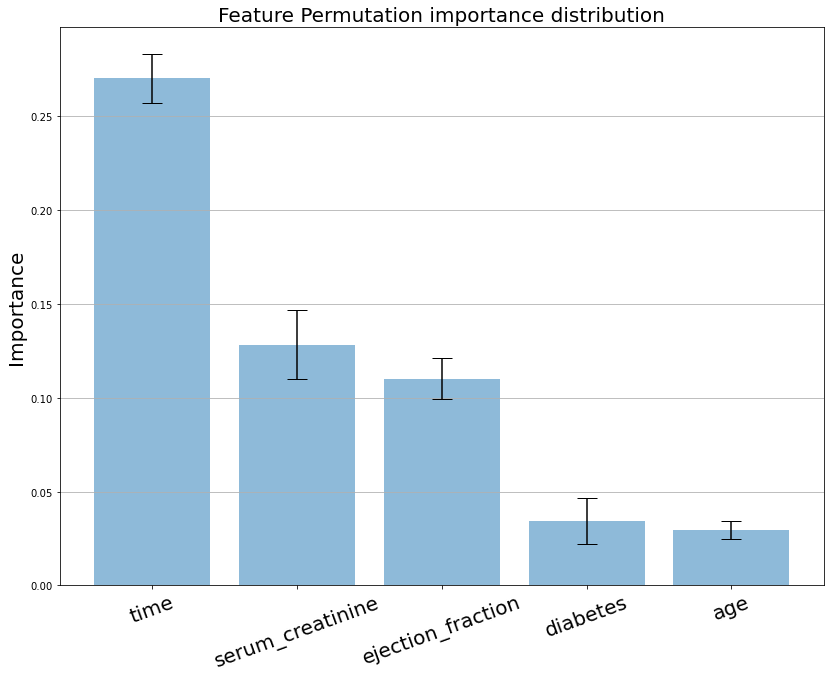

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 10.27)
ax.bar(feat_perm_df['feature'], feat_perm_df['weight'], yerr=feat_perm_df['std'], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Importance', fontsize=20)
ax.set_xticks(feat_perm_df['feature'])
ax.set_xticklabels(feat_perm_df['feature'], fontsize=20,rotation=20 )
ax.set_title('Feature Permutation importance distribution', fontsize=20)
ax.yaxis.grid(True)

In [27]:
# With X_test
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(extratree_clf).fit(df_X_test_featsel,y_test)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=features_selected_xtree)
feat_perm_df


,feature,weight,std
0,time,1.844444e-01,0.024944
1,ejection_fraction,7.555556e-02,0.023727
2,serum_creatinine,5.111111e-02,0.031895
3,age,2.220446e-17,0.018592
4,diabetes,-1.111111e-02,0.007027


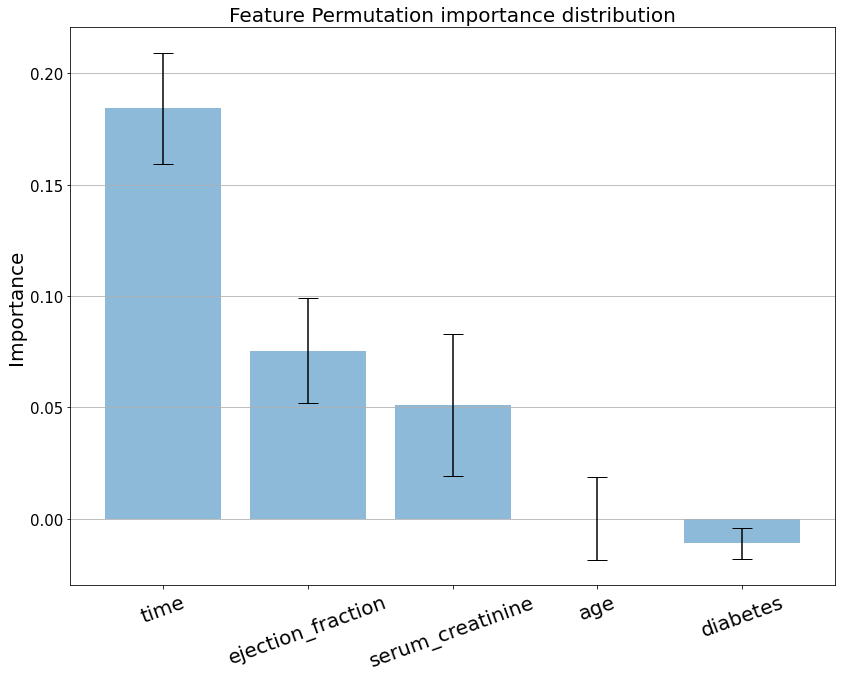

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 10.27)
ax.bar(feat_perm_df['feature'], feat_perm_df['weight'], yerr=feat_perm_df['std'], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Importance', fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.set_xticks(feat_perm_df['feature'])
ax.set_xticklabels(feat_perm_df['feature'], fontsize=20,rotation=20)
ax.set_title('Feature Permutation importance distribution', fontsize=20)
ax.yaxis.grid(True)


In [29]:
###################################################################################################################
##Step 9 PDP plots
#############################################################

from pdpbox import pdp, get_dataset, info_plots
pipe_pdp_xtree=Pipeline([('data_prep',dataprep_merge_feat_xtree),
                          ('clf', extratree_clf)])
model=pipe_pdp_xtree.fit(X_train_feat_sel,y_train)



 Mon Jun  5 16:28:47 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Mon Jun  5 16:28:47 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Mon Jun  5 16:28:47 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:28:47 2023 >>>>>>>>Calling init() from Category_Imputer

 Mon Jun  5 16:28:47 2023 >>>>>>>>Calling fit() from Category_Imputer

 Mon Jun  5 16:28:47 2023 >>>>>>>>Calling transform() from Category_Imputer



 Mon Jun  5 16:28:52 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:28:52 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:28:52 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:28:52 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:28:52 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:28:52 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:28:52 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:28:52 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:28:52 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:28:52 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:28:52 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:28:52 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:28:52 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon 

Text(0.5, 1.0, 'distribution of data points')

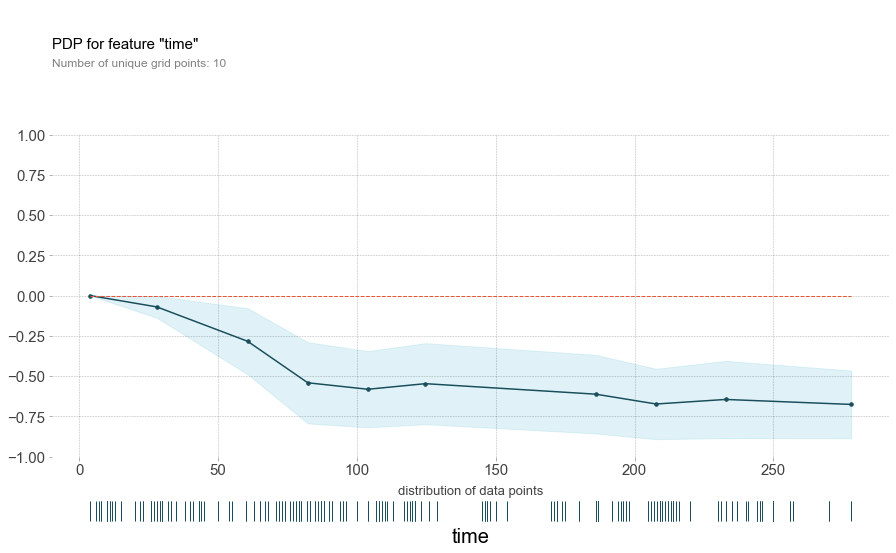

In [30]:
pdp_age_Xtrain= pdp.pdp_isolate(model=model, dataset=X_train_feat_sel, model_features=X_train_feat_sel.columns, feature='time')
fig,axes=pdp.pdp_plot(pdp_age_Xtrain, 'time',plot_pts_dist=True, frac_to_plot=0.5)
axes['pdp_ax']['_pdp_ax'].set_ylim(ymin=-1, ymax=1)
axes['pdp_ax']['_pdp_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].set_xlabel('time', fontsize=20)
axes['pdp_ax']['_count_ax'].set_title('distribution of data points', fontsize=13)



 Mon Jun  5 16:29:10 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:29:10 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:29:10 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:29:10 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:29:10 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:29:10 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:29:10 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:29:10 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:29:10 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:29:10 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:29:11 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:29:11 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:29:11 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon 

Text(0.5, 1.0, 'distribution of data points')

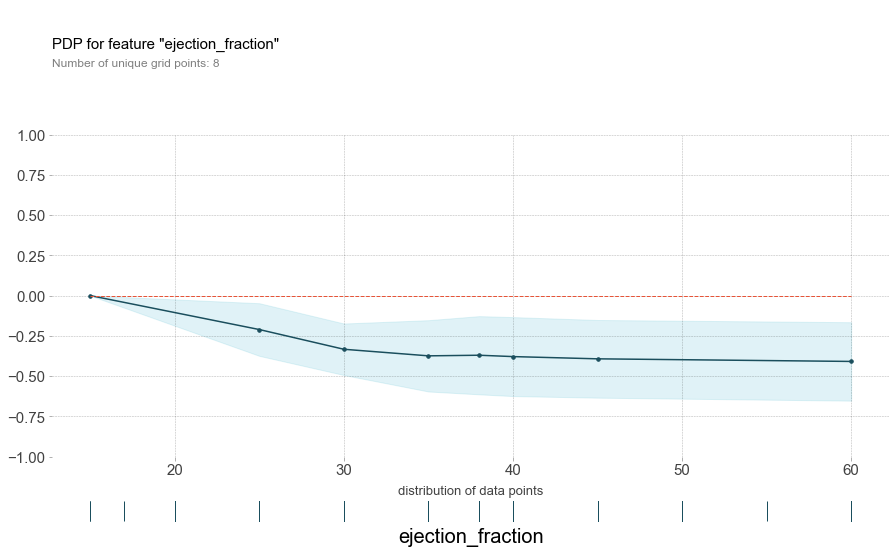

In [31]:
pdp_age_Xtrain= pdp.pdp_isolate(model=model, dataset=X_train_feat_sel, model_features=X_train_feat_sel.columns, feature='ejection_fraction')
fig,axes=pdp.pdp_plot(pdp_age_Xtrain, 'ejection_fraction',plot_pts_dist=True, frac_to_plot=0.5)
axes['pdp_ax']['_pdp_ax'].set_ylim(ymin=-1, ymax=1)
axes['pdp_ax']['_pdp_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].set_xlabel('ejection_fraction', fontsize=20)
axes['pdp_ax']['_count_ax'].set_title('distribution of data points', fontsize=13)


 Mon Jun  5 16:29:20 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:29:20 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:29:20 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:29:20 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:29:20 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:29:20 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:29:20 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:29:20 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:29:20 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:29:20 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:29:20 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:29:20 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:29:20 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon 

Text(0.5, 1.0, 'distribution of data points')

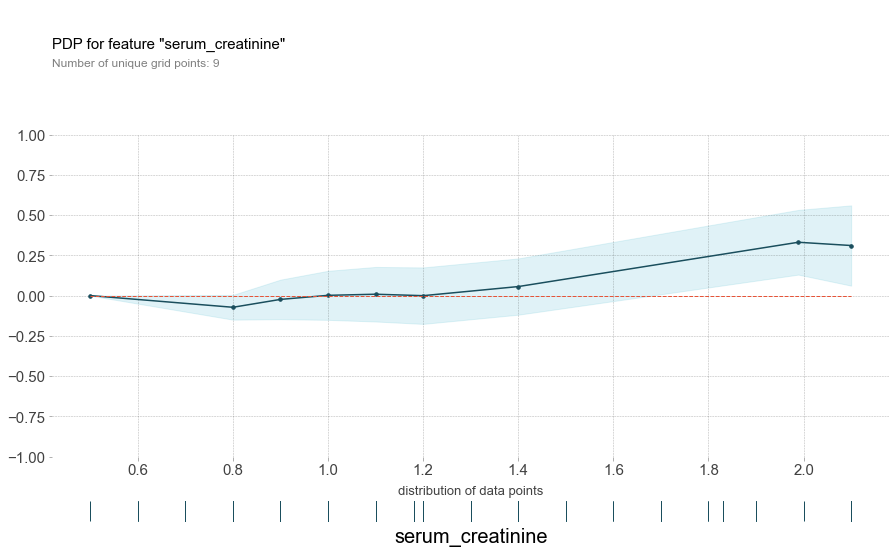

In [32]:
pdp_age_Xtrain= pdp.pdp_isolate(model=model, dataset=X_train_feat_sel, model_features=X_train_feat_sel.columns, feature='serum_creatinine')
fig,axes=pdp.pdp_plot(pdp_age_Xtrain, 'serum_creatinine',plot_pts_dist=True, frac_to_plot=0.5)
axes['pdp_ax']['_pdp_ax'].set_ylim(ymin=-1, ymax=1)
axes['pdp_ax']['_pdp_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].set_xlabel('serum_creatinine', fontsize=20)
axes['pdp_ax']['_count_ax'].set_title('distribution of data points', fontsize=13)



 Mon Jun  5 16:32:17 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:32:17 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:32:17 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:32:17 2023 >>>>>>>>Calling transform() from Category_Imputer


ValueError: The number of FixedLocator locations (0), usually from a call to set_ticks, does not match the number of ticklabels (2).

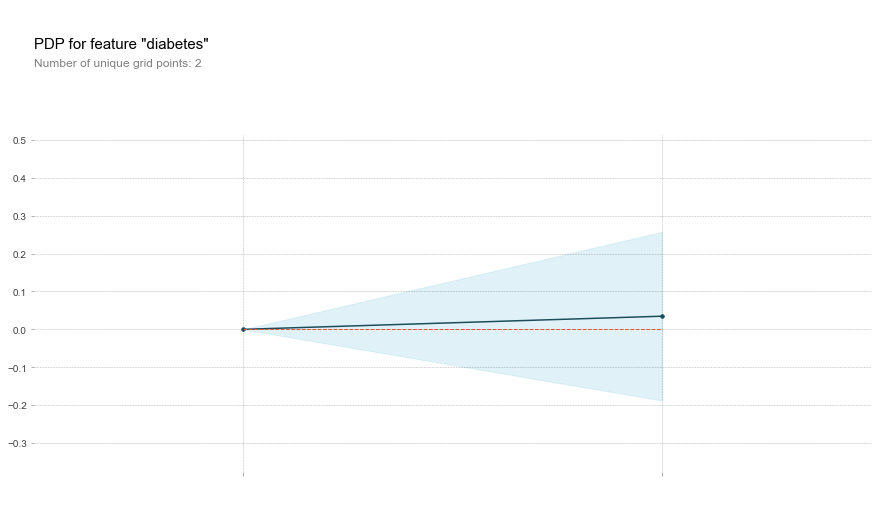

In [37]:
pdp_age_Xtrain= pdp.pdp_isolate(model=model, dataset=X_train_feat_sel, model_features=X_train_feat_sel.columns, feature='diabetes')
fig,axes=pdp.pdp_plot(pdp_age_Xtrain, 'diabetes',plot_pts_dist=True, frac_to_plot=0.5)
axes['pdp_ax']['_pdp_ax'].set_ylim(ymin=-1, ymax=1)
axes['pdp_ax']['_pdp_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].set_xlabel('diabetes', fontsize=20)
axes['pdp_ax']['_count_ax'].set_title('distribution of data points', fontsize=13)



 Mon Jun  5 16:30:18 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:30:18 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:30:18 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:30:18 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:30:18 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:30:18 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:30:18 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:30:18 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:30:18 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:30:18 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:30:18 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:30:18 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:30:18 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon 

Text(0.5, 1.0, 'distribution of data points')

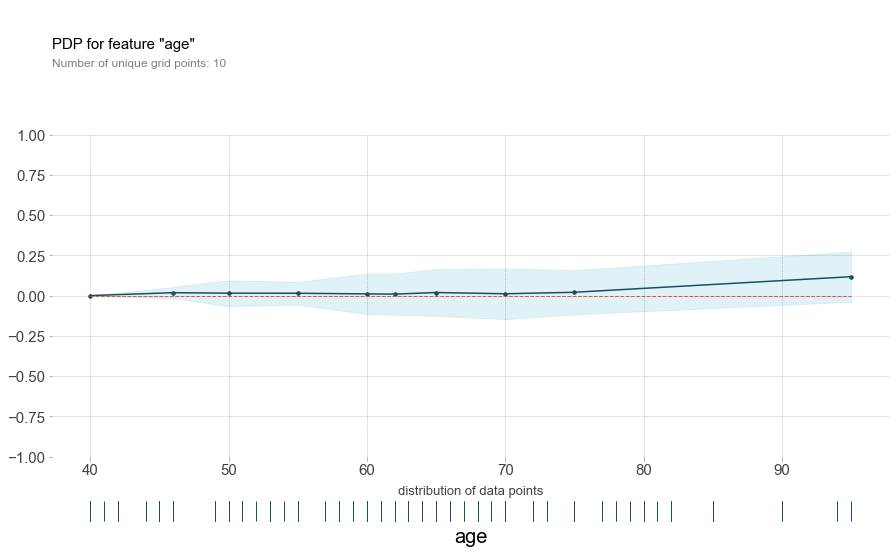

In [34]:
pdp_age_Xtrain= pdp.pdp_isolate(model=model, dataset=X_train_feat_sel, model_features=X_train_feat_sel.columns, feature='age')
fig,axes=pdp.pdp_plot(pdp_age_Xtrain, 'age',plot_pts_dist=True, frac_to_plot=0.5)
axes['pdp_ax']['_pdp_ax'].set_ylim(ymin=-1, ymax=1)
axes['pdp_ax']['_pdp_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].set_xlabel('age', fontsize=20)
axes['pdp_ax']['_count_ax'].set_title('distribution of data points', fontsize=13)


In [38]:
###################################################################################################################
## Step 10 2D partial dependece plots
##############################################################
feat_comb1=['time','ejection_fraction']
feat_comb2=['time','serum_creatinine']
feat_comb3=['ejection_fraction','serum_creatinine']

comb1=pdp.pdp_interact(model=model, dataset=X_train_feat_sel, model_features=X_train_feat_sel.columns, features=feat_comb1)
comb2=pdp.pdp_interact(model=model, dataset=X_train_feat_sel, model_features=X_train_feat_sel.columns, features=feat_comb2)
comb3=pdp.pdp_interact(model=model, dataset=X_train_feat_sel, model_features=X_train_feat_sel.columns, features=feat_comb3)



 Mon Jun  5 16:34:33 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:34:33 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:34:33 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:34:33 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:34:33 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:34:33 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:34:33 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:34:33 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:34:33 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:34:33 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:34:33 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:34:33 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 16:34:33 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon 

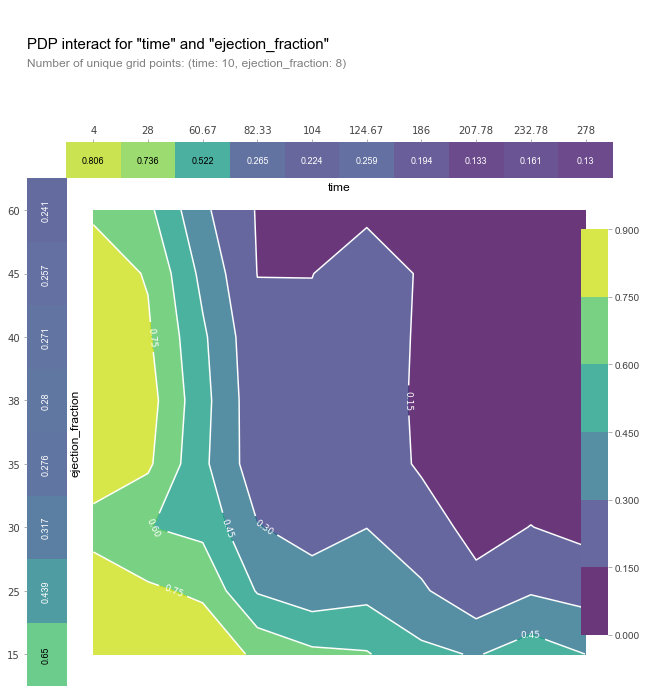

In [39]:
pdp.pdp_interact_plot(pdp_interact_out=comb1, feature_names=feat_comb1, plot_type='contour', x_quantile=True, plot_pdp=True)
plt.show()



 Mon Jun  5 16:35:36 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:35:36 2023 >>>>>>>>Calling transform() from Category_Imputer


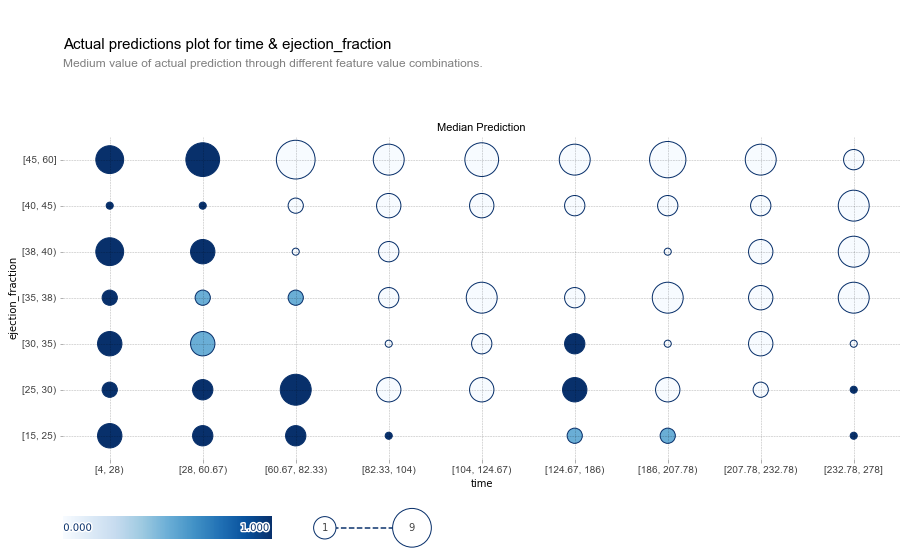

In [40]:
fig, axes, summary_df = info_plots.actual_plot_interact(model=model, X=X_train_feat_sel, features=feat_comb1, feature_names=feat_comb1)


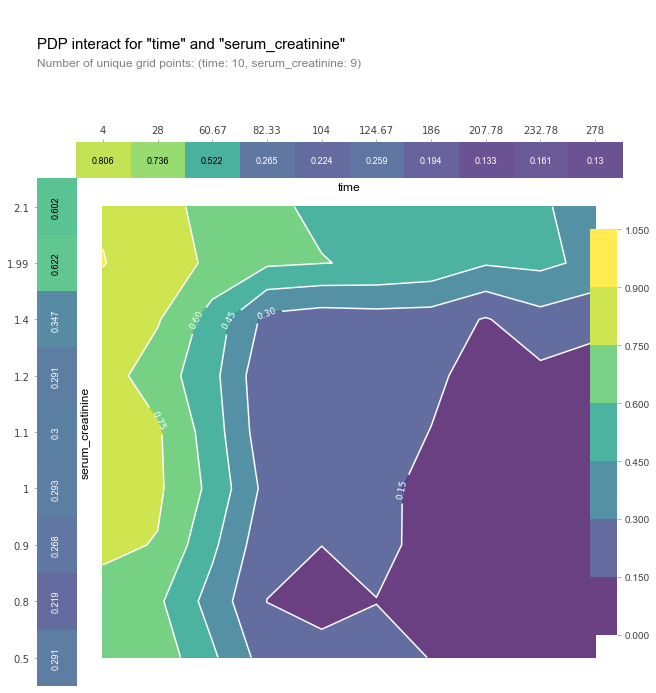

In [41]:
#Ploting ['time','serum_creatinine']
pdp.pdp_interact_plot(pdp_interact_out=comb2, feature_names=feat_comb2, plot_type='contour', x_quantile=True, plot_pdp=True)
plt.show()



 Mon Jun  5 16:36:39 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:36:39 2023 >>>>>>>>Calling transform() from Category_Imputer


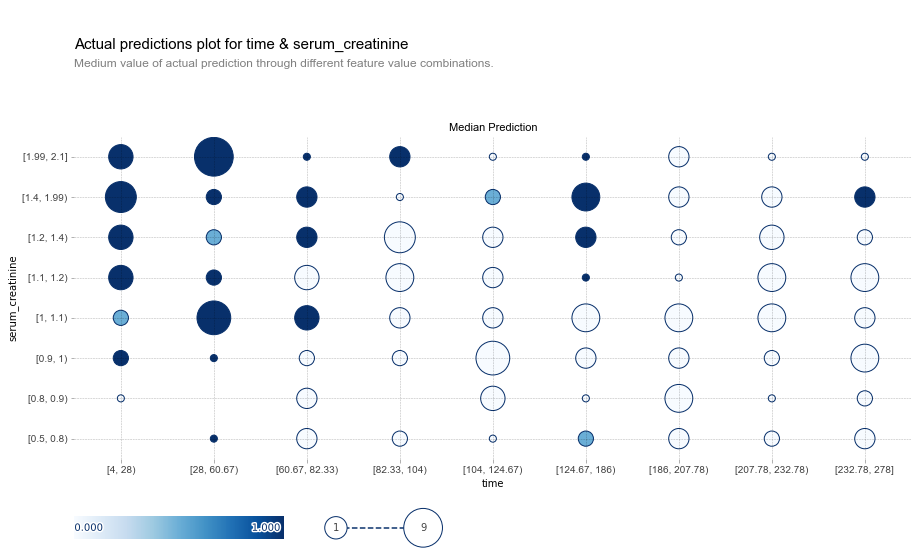

In [42]:
fig, axes, summary_df = info_plots.actual_plot_interact(model=model, X=X_train_feat_sel, features=feat_comb2, feature_names=feat_comb2)


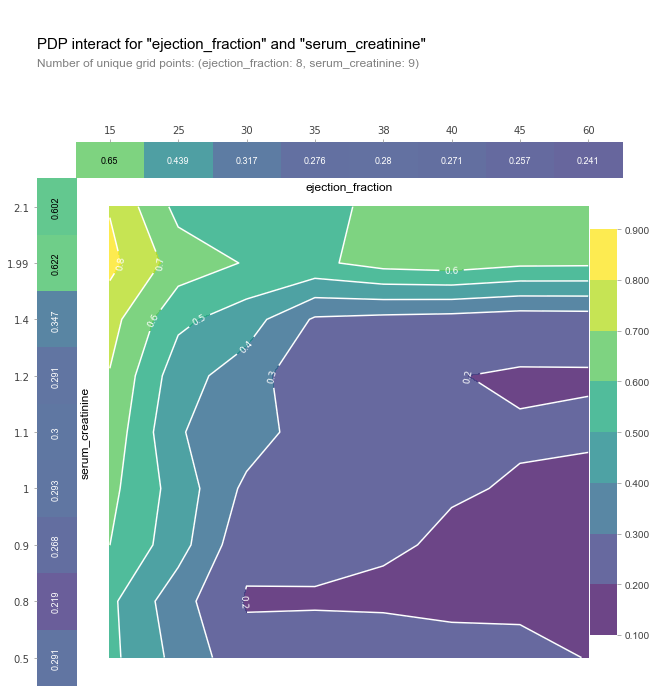

In [43]:
#Ploting ['ejection_fraction','serum_creatinine'']
pdp.pdp_interact_plot(pdp_interact_out=comb3, feature_names=feat_comb3, plot_type='contour', x_quantile=True, plot_pdp=True)
plt.show()



 Mon Jun  5 16:37:30 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 16:37:30 2023 >>>>>>>>Calling transform() from Category_Imputer


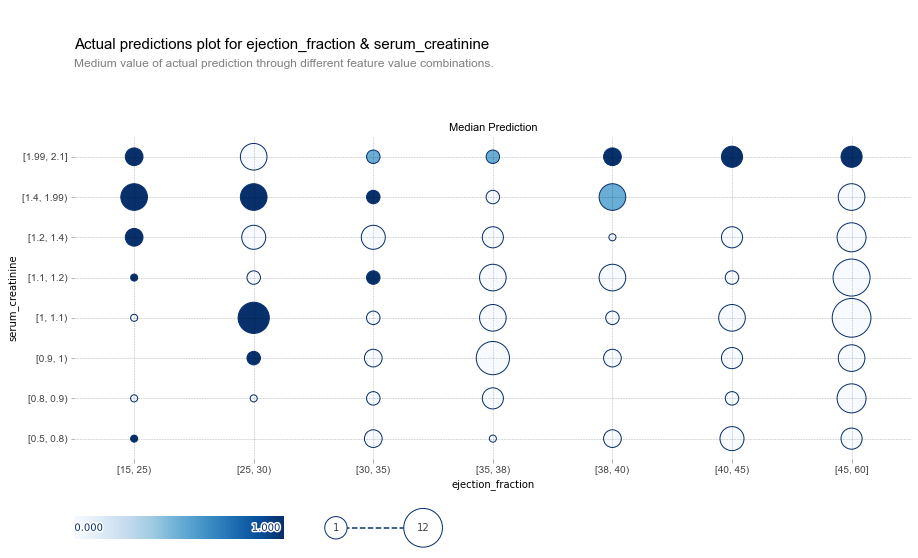

In [44]:
fig, axes, summary_df = info_plots.actual_plot_interact(model=model, X=X_train_feat_sel, features=feat_comb3, feature_names=feat_comb3)

In [ ]:
###################################################################################################################
## Step 11 SHAP explainability 
##############################################################

#global explainability
##################################################################
import shap
shap.initjs()

pipe_shap_xtree=Pipeline([('data_prep',dataprep_merge_feat_xtree),
                          ('clf', extratree_clf)])
pipe_shap_xtree.fit(X_train_feat_sel, y_train)

explainer=shap.explainers.Tree(pipe_shap_xtree.named_steps['clf'], pipe_shap_xtree.named_steps['data_prep'].fit_transform(X_train_feat_sel))
shap_values=explainer.shap_values(pipe_shap_xtree.named_steps['data_prep'].fit_transform(X_train_feat_sel))


In [ ]:
np.shape(shap_values)


In [ ]:
shap.summary_plot(shap_values, X_train_feat_sel,plot_type="bar")

In [ ]:
shap.summary_plot(shap_values[0], X_train_feat_sel,plot_type="dot")

In [ ]:
shap.summary_plot(shap_values[1], X_train_feat_sel,plot_type="dot")


In [ ]:
X_train_feat_sel.head()


In [ ]:
#local explainability
##########################################################
explainer=shap.explainers.Tree(pipe_shap_xtree.named_steps['clf'], pipe_shap_xtree.named_steps['data_prep'].fit_transform(X_test_feat_sel))
shap_values=explainer.shap_values(pipe_shap_xtree.named_steps['data_prep'].fit_transform(X_test_feat_sel))


In [ ]:
np.shape(shap_values)

In [ ]:
#True negative instance
index_TN_shap=5
print(X_test_feat_sel.iloc[index_TN_shap])
print('Actual Label:', y_test[index_TN_shap])
print('Predicted Label:', y_pred[index_TN_shap])
choosen_instance_tn=X_test_feat_sel.iloc[index_TN_shap]


In [ ]:
shap_values_tn = explainer.shap_values(choosen_instance_tn)
shap.force_plot(explainer.expected_value[0], shap_values_tn[0], choosen_instance_tn)


In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values_tn[0], choosen_instance_tn)


In [ ]:
index_TP_shap=2
print(X_test_feat_sel.iloc[index_TP_shap])
print('Actual Label:', y_test[index_TP_shap])
print('Predicted Label:', y_pred[index_TP_shap])
choosen_instance_tp=X_test_feat_sel.iloc[index_TP_shap]


In [ ]:
shap_values_tp = explainer.shap_values(choosen_instance_tp)
shap.force_plot(explainer.expected_value[1], shap_values_tp[1], choosen_instance_tp)
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values_tp[1], choosen_instance_tp)


In [ ]:
index_TN_shap_train = 1
print(df_X_train_featsel.iloc[index_TN_shap_train])
print(X_train_feat_sel.iloc[index_TN_shap_train])
print('Actual Label:', y_train[index_TN_shap_train])
print('Predicted Label:', y_pred_train[index_TN_shap_train])
choosen_instance_tn_train=X_train_feat_sel.iloc[index_TN_shap_train]

In [ ]:
shap_values_tn_train = explainer.shap_values(choosen_instance_tn_train)
shap.force_plot(explainer.expected_value[0], shap_values_tn_train[0], choosen_instance_tn_train)

In [ ]:
shap_values_tn_train

In [ ]:
index_TP_shap_train = 7
print(df_X_train_featsel.iloc[index_TP_shap_train])
print(X_train_feat_sel.iloc[index_TP_shap_train])
print('Actual Label:', y_train[index_TP_shap_train])
print('Predicted Label:', y_pred_train[index_TP_shap_train])
choosen_instance_tp_train=X_train_feat_sel.iloc[index_TP_shap_train]

In [ ]:
shap_values_tp_train = explainer.shap_values(choosen_instance_tp_train)
shap.force_plot(explainer.expected_value[1], shap_values_tp_train[1], choosen_instance_tp_train)

In [ ]:
###################################################################################################################
## Step 12 LIME
##############################################################
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train_feat_sel), feature_names=np.array(X_train_feat_sel.columns), class_names=np.array([0, 1]), mode="classification",discretize_continuous=False)


In [ ]:
index=0
exp = explainer.explain_instance(X_train_feat_sel.iloc[index,:].values, pipe_shap_xtree.named_steps['clf'].predict_proba, num_features=5)

In [ ]:
exp.show_in_notebook(show_table = True, show_all= False)
